In [1]:
# install
# pip install novosparc

In [2]:
# imports
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr



import random
random.seed(0)

In [3]:
import cv2 as cv
from skimage import io, color
import torch
from torch.nn import functional as F
import json

In [4]:
%cd /lustre03/project/6075067/calcium/2021/CeLEry

/lustre03/project/6075067/calcium/2021/CeLEry


In [5]:
from data.MouseBrain.MP1_SVG import d_g

In [6]:
import sys
sys.path.append('/lustre03/project/6075067/calcium/2021/CeLEry/CeLEry_package')

import CeLEry as cel
cel.__version__

'1.1.2'

In [7]:
sys.path.append('/lustre03/project/6075067/calcium/2021/CeLEry/SpaOTsc_package')

from spaotsc import SpaOTsc

##  1. Data Preperation
### Load MouseBarin Data Section 1: Spatial Transcriptomic Data


In [8]:
dataSection1full = sc.read("data/MouseBrain/MP1_sudo.h5ad")
genename = dataSection1full.var['genename']

In [9]:
# Get the gene list from the pre-screening
genelistlist = [d_g[i] for i in  range(len(d_g))]  # transform dictionary to a list of lists
genelist = sum(genelistlist, [])  # merge the list of lists
genelistuni = list( dict.fromkeys(genelist) )   # remove duplicates

genelistindex = [genename[genename == i].index[0] for i in genelistuni if  len(genename[genename == i])>0]


In [10]:
#Read in hitology image
ImageSec1=io.imread("data/MouseBrain/V1_Mouse_Brain_Sagittal_Posterior_image.tif")
ImageSec1sub = ImageSec1[3000:7000,6200:10500,:]
# spc.printimage (ImageSec1sub, "../output/CeLEry/imageselect")


In [11]:
imgray = cv.cvtColor(ImageSec1sub, cv.COLOR_BGR2GRAY)
imgray2 = imgray.copy()
imgray2[imgray2<160] = 0
imgray2[imgray2>160] = 255

## Take the subset of dataSection1
xcords = dataSection1full.obs["x"].to_numpy()
ycords = dataSection1full.obs["y"].to_numpy()

Section1Sub = dataSection1full[(xcords>=3000) & (xcords<7000) & (ycords>=6200) & (ycords<10500), genelistindex]
Section1Sub.obs = Section1Sub.obs/50
Section1Sub.obs = Section1Sub.obs.astype(int)
Section1Sub.obs["inner"] = 0

## Quality Control

for i in range(Section1Sub.obs.shape[0]):
    xi = Section1Sub.obs["x"][i]
    yi = Section1Sub.obs["y"][i]
    subarea = np.mean(imgray2[(xi*50-3000):(xi*50+50-3000), (yi*50-6200):(yi*50+50-6200)])
    if subarea<140 or xi*50>6000:
         Section1Sub.obs["inner"].iloc[i] = 1
    if yi*50>10200 or xi*50<1000:
         Section1Sub.obs["inner"].iloc[i] = 0

Section1Sub = Section1Sub[Section1Sub.obs["inner"] == 1]


Load the index of holdoff. Making sure all methods are comparable.

In [12]:
cel.get_zscore(Section1Sub)

# random.seed(2021)
# torch.manual_seed(2021)
# np.random.seed(2021)

# index10 = random.sample(range(Section1Sub.shape[0]), int(Section1Sub.shape[0]*0.1))
# index30 = random.sample(range(Section1Sub.shape[0]), int(Section1Sub.shape[0]*0.3))
# index50 = random.sample(range(Section1Sub.shape[0]), int(Section1Sub.shape[0]*0.5))

# np.save("../output/CeLEry/index10.npy", index10)
# np.save("../output/CeLEry/index30.npy", index30)
# np.save("../output/CeLEry/index50.npy", index50)

index10 = np.load("output/CeLEry/index10.npy")
index30 = np.load("output/CeLEry/index30.npy")
index50 = np.load("output/CeLEry/index50.npy")


In [13]:
# split the data into training and testing data

# 10% hold off
Section1train10 = Section1Sub[list(set(range(Section1Sub.shape[0]))-set(index10)),]
Section1test10 = Section1Sub[list(set(index10)),]

# 30% hold off
Section1train30 = Section1Sub[list(set(range(Section1Sub.shape[0]))-set(index30)),]
Section1test30 = Section1Sub[list(set(index30)),]

# 50% hold off
Section1train50 = Section1Sub[list(set(range(Section1Sub.shape[0]))-set(index50)),]
Section1test50 = Section1Sub[list(set(index50)),]


In [14]:
def spaOTsc_run(holdoff, datatrain, datatest):
    random.seed(2021)
    torch.manual_seed(2021)
    np.random.seed(2021)
    ## Running spaOTsc
    df_sc = pd.DataFrame(datatest.X)
    is_dmat = cdist(datatrain.obs.to_numpy()[:,0:2], datatrain.obs.to_numpy()[:,0:2], 'minkowski', p=2.)
    sc_dmat = cdist(datatest.X, datatest.X, 'minkowski', p=2.)
    spsc = SpaOTsc.spatial_sc(sc_data=df_sc, is_dmat=is_dmat, sc_dmat=sc_dmat)
    cost_matrix = cdist(datatest.X, datatrain.X, 'minkowski', p=2.)
          
    location_pred = spsc.transport_plan(cost_matrix)
    
    ## For each cell  of the "scRNA", find the predicted location on Spatial map
    S1_xmax = datatrain.obs['x'].max() + 1
    S1_xmin = datatrain.obs['x'].min() - 1
    S1_ymax = datatrain.obs['y'].max() + 1
    S1_ymin = datatrain.obs['y'].min() - 1
    #
    S2_xmax = datatest.obs['x'].max() + 1
    S2_xmin = datatest.obs['x'].min() - 1
    S2_ymax = datatest.obs['y'].max() + 1
    S2_ymin = datatest.obs['y'].min() - 1
    ## Normalize the coordinates of both Sections
    spx = (datatrain.obs.iloc[:,0] - S1_xmin) / (S1_xmax - S1_xmin)
    spy = (datatrain.obs.iloc[:,1] - S1_ymin) / (S1_ymax - S1_ymin)
    truex = (datatest.obs.iloc[:,0] - S2_xmin) / (S2_xmax - S2_xmin)
    truey = (datatest.obs.iloc[:,1] - S2_ymin) / (S2_ymax - S2_ymin)
    #
    total_loss_tg = []
    coords_predict = np.zeros((datatest.obs.shape[0],4))

    for i in range(location_pred.shape[0]):
        bestindex = np.argmax(location_pred[i,:])
        truth = torch.FloatTensor([truex[i],truey[i]])
        pred = torch.FloatTensor([spx[bestindex],spy[bestindex]])
        coords_predict[i,0:2] = pred
        coords_predict[i,2:4] = truth
        loss = F.mse_loss(truth,pred)
        total_loss_tg.append(loss)
    #
    losstotal_itemize = [x.item() for x in total_loss_tg]
    losstotal = sum(losstotal_itemize)
    print('Loss for enhancement data only:{:.4f}'.format(float(losstotal)))
    #
    np.savetxt("output/CeLEry/spaOTsc/location_{holdoff}_predict.csv".format(holdoff = holdoff), coords_predict)
    #
    cel.RelocationPlot(coords_predict, datatest.obs[["x","y"]], filename = "output/CeLEry/spaOTsc/location_{holdoff}".format(holdoff = holdoff), linewidth =1.5)
    SSIM_result =  cel.get_SSIM(coords_predict, referadata = datatest, trainAnn = datatrain, referlocation = datatest.obs[["x","y"]], genelist = range(datatest.X.shape[1]))
    cel.plotGeneImg(cel.centralize2(SSIM_result[1][0,:,:,0]), filename = "output/CeLEry/spaOTsc/spaOTsc_{holdoff}_SSIM_1".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[2][0,:,:]), filename = "output/CeLEry/spaOTsc/spaOTsc_{holdoff}_SSIM_anchor_1".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[1][1,:,:,0]), filename = "output/CeLEry/spaOTsc/spaOTsc_{holdoff}_SSIM_2".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[2][1,:,:]), filename = "output/CeLEry/spaOTsc/spaOTsc_{holdoff}_SSIM_anchor_2".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[1][2,:,:,0]), filename = "output/CeLEry/spaOTsc/spaOTsc_{holdoff}_SSIM_3".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[2][2,:,:]), filename = "output/CeLEry/spaOTsc/spaOTsc_{holdoff}_SSIM_anchor_3".format(holdoff = holdoff))
    np.save("output/CeLEry/spaOTsc/spaOTsc_{holdoff}_SSIM.npy".format(holdoff = holdoff), np.array(SSIM_result[0]))
    np.save("output/CeLEry/spaOTsc/spaOTsc_{holdoff}_cor.npy".format(holdoff = holdoff), np.array(SSIM_result[3]))
    np.save("output/CeLEry/spaOTsc/spaOTsc_{holdoff}_MSE.npy".format(holdoff = holdoff), np.array(SSIM_result[4]))
    del SSIM_result
    #
    #result_tg = sc.AnnData(X= np.expand_dims(np.array(losstotal_itemize),  axis = 1))
    #result_tg.obs = dataSection2.obs[["x","y"]]
    #cel.getGeneImg(result_tg, emptypixel = -0.1)
    #cel.plotGeneImg(result_tg.GeneImg[0,:,:],filename = "output/CeLEry/spaOTsc/imgDNNspaOTsc_{holdoff}".format(holdoff = holdoff), range = (-0.1,0.6))
    #
    #
    results = {"MSE":str(round(losstotal,4))}
    with open("output/CeLEry/spaOTsc/spaOTsc_results_{holdoff}.txt".format(holdoff = holdoff), 'w') as file:
        file.write(json.dumps(results))


Loss for enhancement data only:0.6332


100%|██████████| 358/358 [00:04<00:00, 74.78it/s]


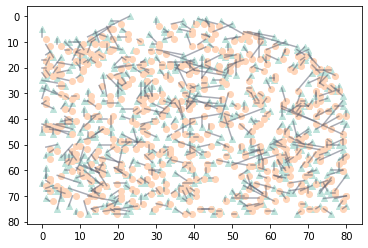

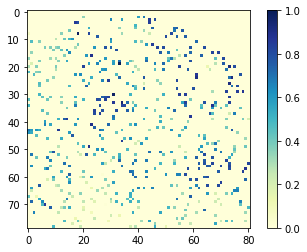

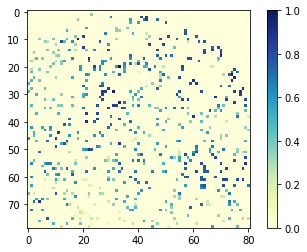

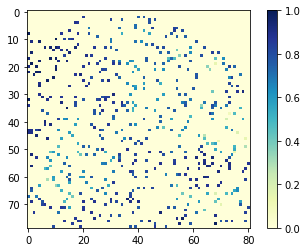

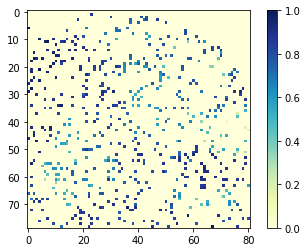

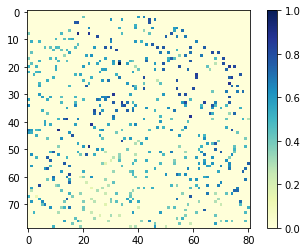

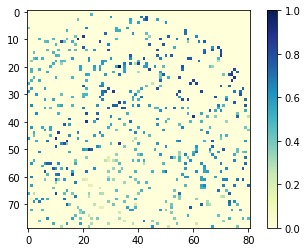

In [15]:
spaOTsc_run(holdoff = 10, datatrain = Section1train10, datatest = Section1test10)

Loss for enhancement data only:2.6279


100%|██████████| 358/358 [00:13<00:00, 25.68it/s]


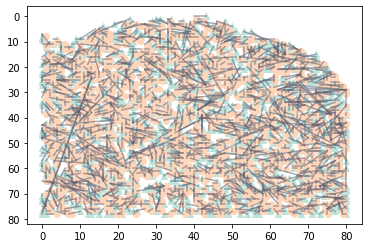

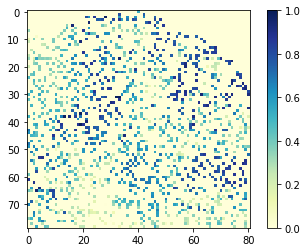

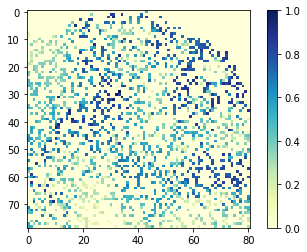

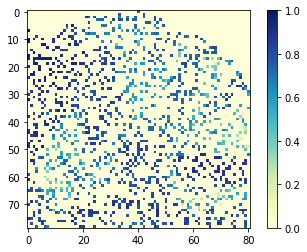

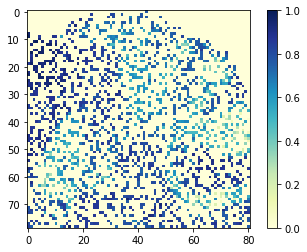

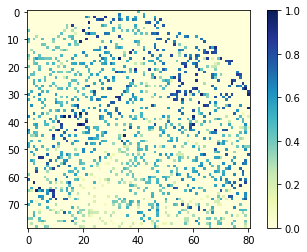

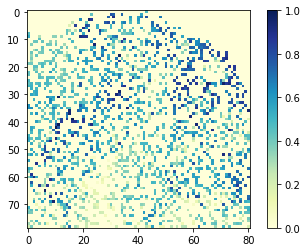

In [16]:
spaOTsc_run(holdoff = 30, datatrain = Section1train30, datatest = Section1test30)

Loss for enhancement data only:4.1478


100%|██████████| 358/358 [00:22<00:00, 15.69it/s]


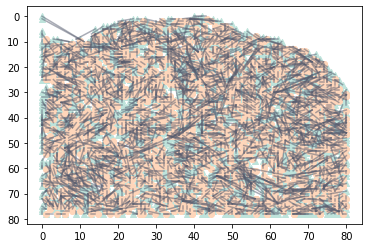

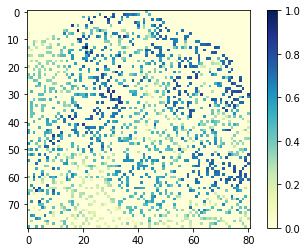

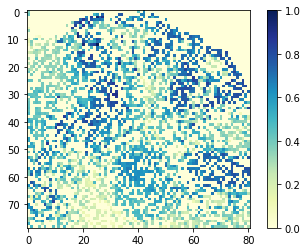

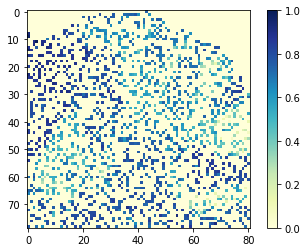

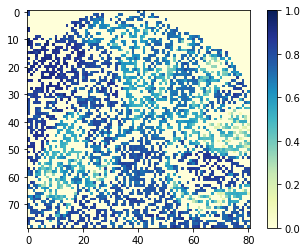

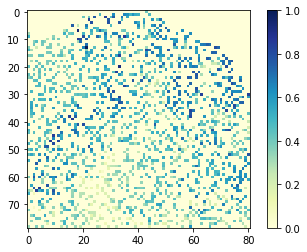

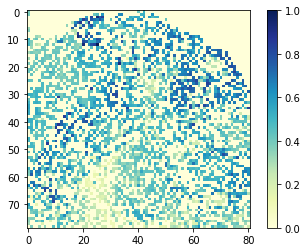

In [17]:
spaOTsc_run(holdoff = 50, datatrain = Section1train50, datatest = Section1test50)